# Vanila Policy Gradient Algorithm on CartPole-**v0**

Dependencies
* !pip install tensorflow-gpu==2.4.1
* !pip install tensorflow-probability
* !pip install gym
* !apt update && apt install xvfb
* !pip install gym-notebook-wrapper

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
class Actor(tf.keras.Model):
    
    def __init__(self):
        super(Actor, self).__init__()
        self.layer1=tf.keras.layers.Dense(128,"relu",input_shape=(4,))
        self.layer2=tf.keras.layers.Dense(128,"relu")
        self.layer3=tf.keras.layers.Dense(128,"relu")
        self.layer4=tf.keras.layers.Dense(1,"sigmoid")
        
    def call(self,s):
        net=self.layer1(s)
        net=self.layer2(net)
        net=self.layer3(net)
        net=self.layer4(net)
        return net
    
    def action(self,s):
        s=s.reshape(1,-1)
        net=self.call(s)
        act=tfp.distributions.Bernoulli(probs=net).sample()
        return act.numpy()[0]
    
    def log_prob(self,s,a):
        net=self.call(s)
        dist=tfp.distributions.Bernoulli(probs=net)
        return dist.log_prob(a)
    

class Critic(tf.keras.Model):
    
    def __init__(self):
        super(Critic, self).__init__()
        self.layer1=tf.keras.layers.Dense(128,"relu",input_shape=(4,))
        self.layer2=tf.keras.layers.Dense(128,"relu")
        self.layer3=tf.keras.layers.Dense(128,"relu")
        self.layer4=tf.keras.layers.Dense(1)
        
    def call(self,s):
        net=self.layer1(s)
        net=self.layer2(net)
        net=self.layer3(net)
        net=self.layer4(net)
        return net

In [ ]:
actor=Actor()

critic=Critic()
critic.compile(loss='mse',optimizer='adam')

actor_optimizer=tf.optimizers.Adam(learning_rate=0.0003)

In [ ]:
#S-->(N,4)
#A-->(N,1)
#log pi(A|S)-->(N,1)
#Adv-->(N,1)

#loss=-tf.reduce_sum(tf.multiply(log pi(A|S),Adv))/m

def loss(S,A,Adv):
    m=S.shape[0]
    log_pi_A_given_S=actor.log_prob(S,A)
    return -1* tf.reduce_sum(tf.multiply(log_pi_A_given_S,Adv))/m

In [ ]:
import gnwrapper
import gym
env=gnwrapper.LoopAnimation(gym.make("CartPole-v0"))
env._max_episode_steps=200

In [ ]:
def get_returns_from_rewards(rewards):
    G=[]
    ret=0
    for r in reversed(rewards):
        ret=0.99*ret+r #gamma=0.99
        G.insert(0,ret)
    return np.array(G)

In [ ]:
def get_trijectory():
    states=[]
    actions=[]
    rewards=[]

    curr_state=env.reset()
    done=False

    while not done:
        act=actor.action(curr_state)
        next_state,reward,done,_=env.step(act[0])

        states.append(curr_state)
        actions.append(act)
        rewards.append(reward)

        curr_state=next_state

    G=get_returns_from_rewards(rewards).reshape(-1,1).tolist()
    R=sum(rewards)
    return states,actions,G,R

In [ ]:
def get_experience_on_theta(m):
    states=[];actions=[];G=[];V_theta=0
    for i in range(m):
        S,A,g,R=get_trijectory()
        states.extend(S)
        actions.extend(A)
        G.extend(g)
        V_theta+=R
    return np.array(states),np.array(actions),np.array(G),V_theta/m

In [ ]:
#VPG Algo

In [ ]:
#start
#Initilize Actor(theta) & Critic(theta-1)
#loop till goal V_theta
    #sample m trijectories with Actor theta (done)
    #Adv=G-Citic(S)
    #Critic.update(S,G)
    #Actor update parameters with experience
#end_loop
#end

goal_vtheta=200
v_theta=0

i=1
while v_theta <goal_vtheta:
    S,A,G,v_theta=get_experience_on_theta(200) #m=200
    print(f"{i}: V_theta:{v_theta}")
    
    Adv=G-critic.predict(S)
    
    Adv=(Adv-Adv.mean())/Adv.std() #normalize advantages
    
    critic.fit(S,G,epochs=100,verbose=0)
    
    with tf.GradientTape() as t:
        J=loss(S,A,Adv)
    grads=t.gradient(J,actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(grads,actor.trainable_variables))
    
    i+=1

1: V_theta:20.655
2: V_theta:23.57
3: V_theta:22.77
4: V_theta:23.21
5: V_theta:25.06
6: V_theta:23.935
7: V_theta:24.575
8: V_theta:23.645
9: V_theta:24.93
10: V_theta:24.29
11: V_theta:25.255
12: V_theta:25.81
13: V_theta:26.81
14: V_theta:26.98
15: V_theta:26.27
16: V_theta:25.675
17: V_theta:27.365
18: V_theta:28.36
19: V_theta:30.645
20: V_theta:31.085
21: V_theta:29.855
22: V_theta:32.835
23: V_theta:30.11
24: V_theta:30.74
25: V_theta:30.3
26: V_theta:31.875
27: V_theta:29.51
28: V_theta:32.935
29: V_theta:32.31
30: V_theta:33.93
31: V_theta:34.875
32: V_theta:35.725
33: V_theta:35.715
34: V_theta:36.985
35: V_theta:39.325
36: V_theta:39.815
37: V_theta:37.39
38: V_theta:40.13
39: V_theta:40.44
40: V_theta:42.06
41: V_theta:42.23
42: V_theta:44.75
43: V_theta:43.255
44: V_theta:47.11
45: V_theta:49.25
46: V_theta:46.565
47: V_theta:51.87
48: V_theta:53.245
49: V_theta:52.405
50: V_theta:53.175
51: V_theta:54.405
52: V_theta:61.83
53: V_theta:60.535
54: V_theta:61.64
55: V_theta:

KeyboardInterrupt: ignored

In [ ]:
def test(m=1):
    for i in range(m):
        curr_state=env.reset()
        done=False
        rewd=0
        while not done:
            env.render()
            act=actor.action(curr_state)
            next_state,reward,done,_=env.step(act[0])

            curr_state=next_state
            rewd+=reward
        print(f"{i}: Total Reward:{rewd}")
    env.close()
    env.display()

0: Total Reward:200.0


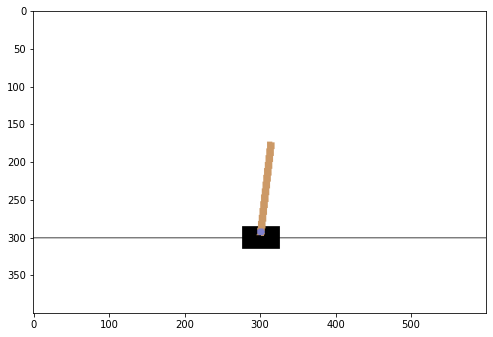

In [ ]:
_=test()

In [ ]:
#NICE